Built 25 Gabor filters.


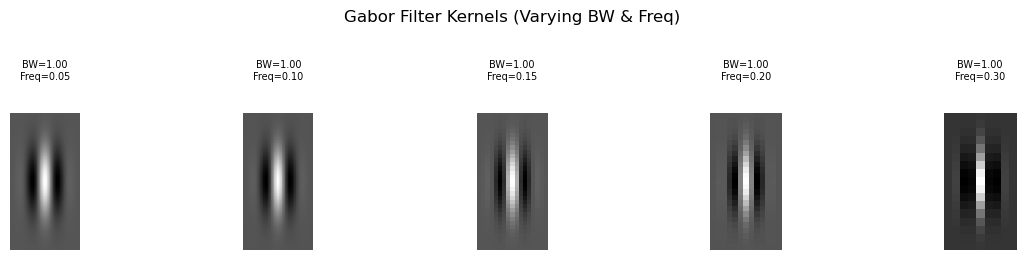

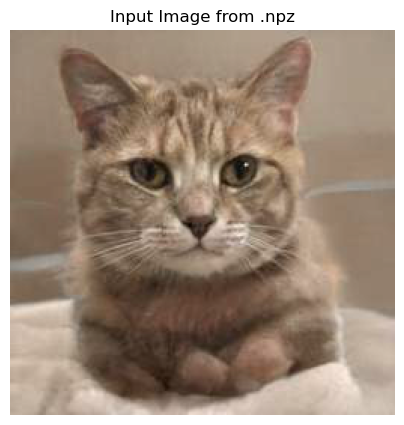

Applying filter bank...
Done.


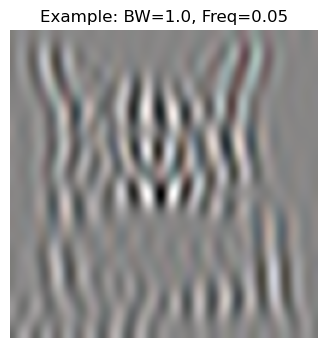

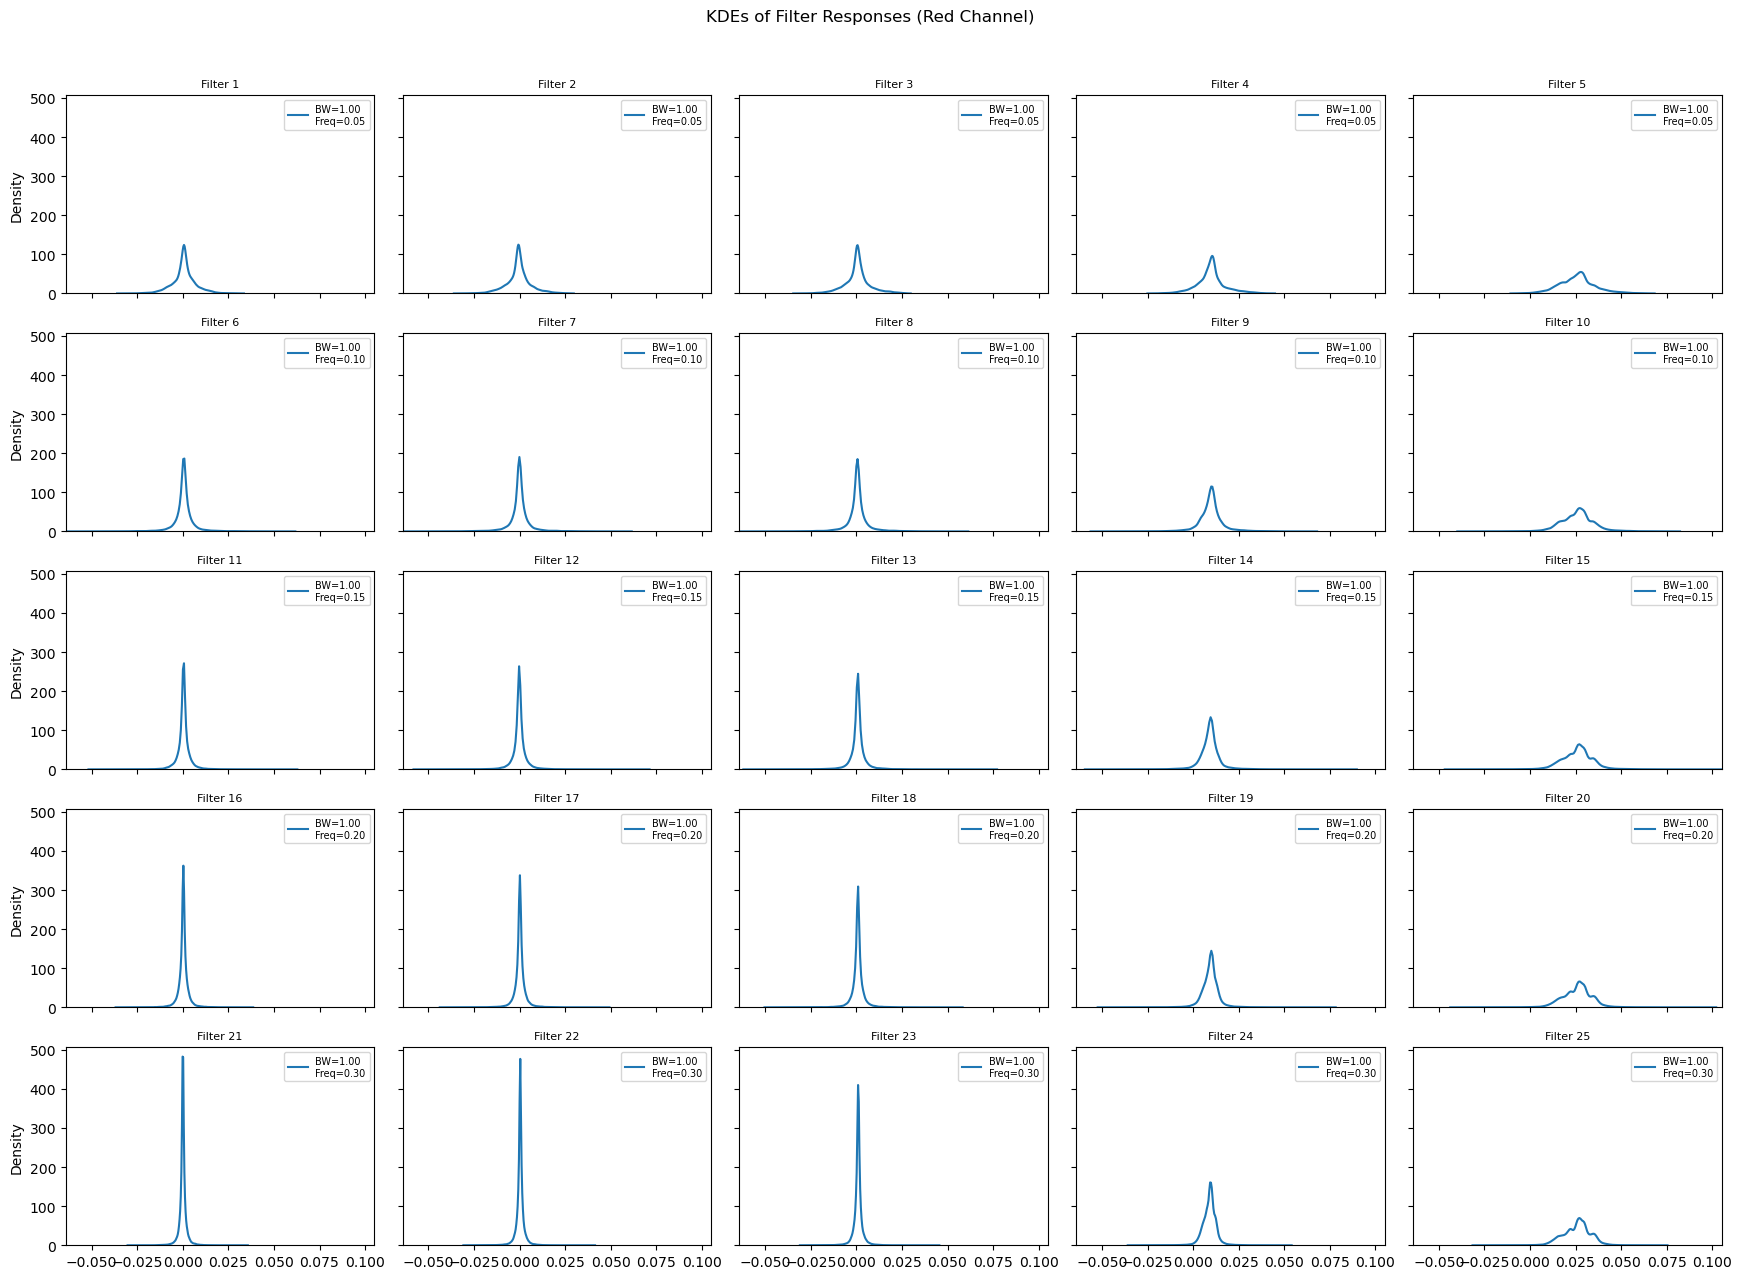

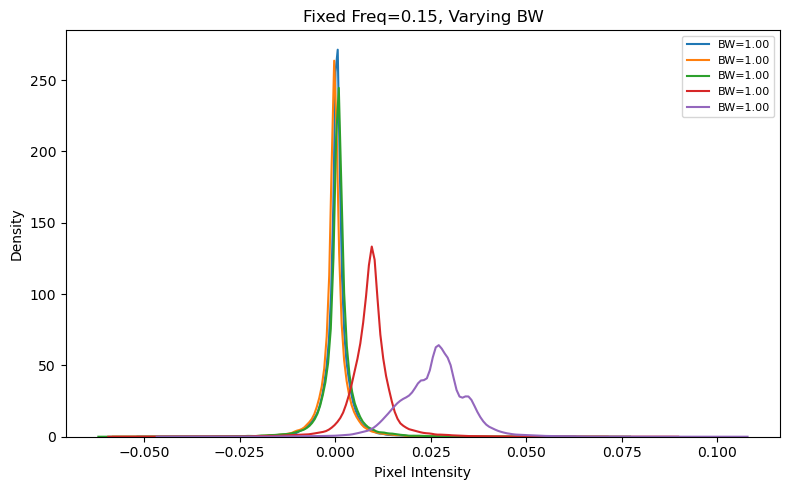

No responses for bw=0.75
No filter for Freq=0.15, BW=0.75
Analysis complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import img_as_float, exposure
from skimage.filters import gabor_kernel
import scipy.ndimage as ndi
from PIL import Image

# ---------------------------
# 1. Build an extended bank of color Gabor filters (Varying Frequency and Bandwidth)
# ---------------------------
def build_gabor_filter_bank_freq_bw(
    frequencies=[0.05, 0.1, 0.2, 0.3, 0.4],
    bandwidths=[0.5, 1, 1.5, 2.0],
    theta=0
):
    """
    Create an extended bank of Gabor filters varying frequency and bandwidth.
    Theta (orientation) is kept fixed.
    """
    filters = []
    for bw in bandwidths:
        for freq in frequencies:
            kernel = np.real(gabor_kernel(frequency=freq, theta=theta, bandwidth=bw))
            kernel_rgb = np.stack([kernel] * 3, axis=-1)
            filters.append({
                'bandwidth': bw,
                'frequency': freq,
                'theta': theta,
                'kernel': kernel,
                'kernel_rgb': kernel_rgb
            })
    return filters

# --- helper: compute isotropic sigma from (frequency, bandwidth) ---
def sigma_from_bandwidth(frequency, bandwidth_octaves):
    """
    Map bandwidth (in octaves) + center frequency -> isotropic sigma.
    Matches the common closed-form used for Gabors.
    """
    b = float(bandwidth_octaves)
    f = float(frequency)
    # constants
    ln2 = np.log(2.0)
    # closed-form relation between sigma and octave bandwidth for Gabors
    # sigma = (sqrt(2*ln2) / (2*pi*f)) * ( (2**b + 1) / (2**b - 1) )
    sigma = (np.sqrt(2*ln2) / (2*np.pi*f)) * ((2**b + 1) / (2**b - 1))
    return sigma

def build_gabor_filter_bank_const_bw_aspect(
    frequencies=(0.05, 0.1, 0.2, 0.3, 0.4),
    bandwidth=1.0,                 # hold this fixed
    gammas=(0.5, 1.0, 2.0),         # aspect ratios γ = σy/σx
    theta=0,
    n_stds=3
):
    """
    Build a bank that keeps bandwidth fixed while sweeping frequency and aspect ratio.
    For each (f, b), compute isotropic sigma, then set (σx, σy) with constant geometric mean.
    """
    filters = []
    for f in frequencies:
        sigma_iso = sigma_from_bandwidth(f, bandwidth)
        for gamma in gammas:
            sx = sigma_iso / np.sqrt(gamma)
            sy = sigma_iso * np.sqrt(gamma)
            kern = np.real(gabor_kernel(frequency=f, theta=theta,
                                        sigma_x=sx, sigma_y=sy, n_stds=n_stds))
            filters.append({
                'bandwidth': bandwidth,
                'frequency': f,
                'theta': theta,
                'gamma': gamma,
                'sigma_x': sx,
                'sigma_y': sy,
                'kernel': kern,
                'kernel_rgb': np.stack([kern]*3, axis=-1)
            })
    return filters


# ---------------------------
# 2. Visualize the Gabor filter bank (kernel view)
# ---------------------------
def plot_filter_bank_freq_bw(filters):
    num_freqs = len(np.unique([f['frequency'] for f in filters]))
    num_bws   = len(np.unique([f['bandwidth'] for f in filters]))
    all_freqs = sorted(np.unique([f['frequency'] for f in filters]))
    all_bws   = sorted(np.unique([f['bandwidth'] for f in filters]))
    filter_map = {(f['bandwidth'], f['frequency']): i for i, f in enumerate(filters)}

    fig, axes = plt.subplots(num_bws, num_freqs,
                             figsize=(num_freqs*2.5, num_bws*2.5),
                             squeeze=False)
    for r, bw in enumerate(all_bws):
        for c, freq in enumerate(all_freqs):
            ax = axes[r, c]
            idx = filter_map.get((bw, freq), None)
            if idx is not None:
                kern = filters[idx]['kernel']
                ax.imshow(kern, cmap='gray')
                ax.set_title(f"BW={bw:.2f}\nFreq={freq:.2f}", fontsize=7)
            ax.axis('off')

    # labels
    for r, bw in enumerate(all_bws):
        axes[r, 0].set_ylabel(f'BW={bw:.2f}', rotation=90, labelpad=15)
    for c, freq in enumerate(all_freqs):
        axes[0, c].set_xlabel(f'Freq={freq:.2f}', labelpad=10)
        axes[0, c].xaxis.set_label_position('top')

    plt.suptitle("Gabor Filter Kernels (Varying BW & Freq)", y=1.02)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 3. Apply the filter bank to an image
# ---------------------------
def apply_filter_bank(image, filters):
    """
    Applies each Gabor filter in the bank to the input RGB image.
    """
    responses = []
    image = img_as_float(image)
    for filt in filters:
        out = np.zeros_like(image)
        for ch in range(3):
            out[:, :, ch] = ndi.convolve(
                image[:, :, ch],
                filt['kernel'],
                mode='reflect'
            )
        responses.append({
            'bandwidth': filt['bandwidth'],
            'frequency': filt['frequency'],
            'theta': filt['theta'],
            'response': out
        })
    return responses

# ---------------------------
# 3a. Reconstruct a normalized RGB image from the filtered response.
# ---------------------------
def reconstruct_normalized_rgb(response):
    norm = np.zeros_like(response)
    for ch in range(3):
        mn, mx = response[:, :, ch].min(), response[:, :, ch].max()
        if mn == mx:
            norm[:, :, ch] = 0
        else:
            norm[:, :, ch] = exposure.rescale_intensity(
                response[:, :, ch],
                in_range='image',
                out_range=(0, 1)
            )
    return norm

# ---------------------------
# 4a. Plot individual KDE plots in a grid
# ---------------------------
def plot_kdes_grid_freq_bw(responses, channel=0, num=None):
    selected = responses if num is None else responses[:num]
    n = len(selected)
    if n == 0:
        print("No responses to plot.")
        return

    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))

    all_vals = np.hstack([
        resp['response'][:, :, channel].ravel() for resp in selected
    ])
    vmin, vmax = all_vals.min(), all_vals.max()

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*3.5, nrows*2.5),
                             sharex=True, sharey=True)
    axes = axes.flatten()
    for i, resp in enumerate(selected):
        ax = axes[i]
        vals = resp['response'][:, :, channel].ravel()
        sns.kdeplot(vals, ax=ax,
                    label=f"BW={resp['bandwidth']:.2f}\nFreq={resp['frequency']:.2f}")
        ax.set_xlim(vmin, vmax)
        ax.legend(fontsize=7)
        ax.set_title(f"Filter {i+1}", fontsize=8)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("KDEs of Filter Responses (Red Channel)", y=1.02)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 4b. Overlay KDE for fixed frequency, varying bandwidth
# ---------------------------
def plot_overlay_fixed_frequency_varying_bandwidth(responses, fixed_frequency, channel=0):
    sel = [r for r in responses if np.isclose(r['frequency'], fixed_frequency)]
    if not sel:
        print(f"No responses for freq={fixed_frequency}")
        return
    plt.figure(figsize=(8,5))
    for r in sorted(sel, key=lambda x: x['bandwidth']):
        vals = r['response'][:, :, channel].ravel()
        sns.kdeplot(vals, label=f"BW={r['bandwidth']:.2f}")
    plt.title(f"Fixed Freq={fixed_frequency}, Varying BW")
    plt.xlabel("Pixel Intensity"); plt.ylabel("Density")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 4c. Overlay KDE for fixed bandwidth, varying frequency
# ---------------------------
def plot_overlay_fixed_bandwidth_varying_frequency(responses, fixed_bandwidth, channel=0):
    sel = [r for r in responses if np.isclose(r['bandwidth'], fixed_bandwidth)]
    if not sel:
        print(f"No responses for bw={fixed_bandwidth}")
        return
    plt.figure(figsize=(8,5))
    for r in sorted(sel, key=lambda x: x['frequency']):
        vals = r['response'][:, :, channel].ravel()
        sns.kdeplot(vals, label=f"Freq={r['frequency']:.2f}")
    plt.title(f"Fixed BW={fixed_bandwidth}, Varying Freq")
    plt.xlabel("Pixel Intensity"); plt.ylabel("Density")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 4d. Overlay KDE for three channels for one filter
# ---------------------------
def plot_overlay_kde_three_channels_freq_bw(responses, fixed_frequency, fixed_bandwidth):
    sel = [r for r in responses
           if np.isclose(r['frequency'], fixed_frequency)
           and np.isclose(r['bandwidth'], fixed_bandwidth)]
    if not sel:
        print(f"No filter for Freq={fixed_frequency}, BW={fixed_bandwidth}")
        return
    r = sel[0]
    names = {0:"Red",1:"Green",2:"Blue"}
    plt.figure(figsize=(8,5))
    for ch in [0,1,2]:
        vals = r['response'][:, :, ch].ravel()
        sns.kdeplot(vals, label=names[ch])
    plt.title(f"Three Channels (Freq={fixed_frequency}, BW={fixed_bandwidth})")
    plt.xlabel("Pixel Intensity"); plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ---------------------------
# 5. Main execution
# ---------------------------
if __name__ == '__main__':
    # --- Define your filter bank parameters ---

    # frequencies = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
    # bandwidths = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5]
    # fixed_theta = 0

    # # (a) Build filter bank
    # gabor_filters = build_gabor_filter_bank_freq_bw(
    #     frequencies=frequencies,
    #     bandwidths=bandwidths,
    #     theta=fixed_theta
    # )

    frequencies = [0.05, 0.1, 0.15, 0.2, 0.3]
    bandwidth  = 1.0            # fixed b (octaves)
    gammas     = [0.5, 0.75, 1.0, 1.5, 2.0]  # aspect ratios
    gabor_filters = build_gabor_filter_bank_const_bw_aspect(
        frequencies=frequencies,
        bandwidth=bandwidth,
        gammas=gammas,
        theta=0
    )

    print(f"Built {len(gabor_filters)} Gabor filters.")

    # (b) Visualize the filter kernels
    plot_filter_bank_freq_bw(gabor_filters)

    # (c) Load your image from a .npz file
    npz_path = '/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/cat1589.jpg'  # <<< set this to your file
    #npz_data = np.load(npz_path)
    img = np.array(Image.open(npz_path).convert('RGB'))
    # print("Available keys in .npz:", npz_data.files)
    # img = npz_data[npz_data.files[0]]      # or replace with specific key

    # Convert grayscale -> RGB if needed, and scale to [0,1]
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    img = img.astype(float)
    if img.max() > 1.0:
        img /= img.max()

    # Quick display
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title("Input Image from .npz")
    plt.axis('off')
    plt.show()

    # (d) Apply the filter bank
    print("Applying filter bank...")
    responses = apply_filter_bank(img, gabor_filters)
    print("Done.")

    # (e) Show one example reconstruction
    ex = responses[0]
    recon = reconstruct_normalized_rgb(ex['response'])
    plt.figure(figsize=(4,4))
    plt.imshow(recon)
    plt.title(f"Example: BW={ex['bandwidth']}, Freq={ex['frequency']}")
    plt.axis('off')
    plt.show()

    # (f) Plot all KDEs (red channel)
    plot_kdes_grid_freq_bw(responses, channel=0)

    # (g1) Overlay: fixed frequency, varying bandwidth
    fixed_freq = frequencies[len(frequencies)//2]
    plot_overlay_fixed_frequency_varying_bandwidth(responses, fixed_freq, channel=0)

    # (g2) Overlay: fixed bandwidth, varying frequency
    fixed_bw = 0.75
    plot_overlay_fixed_bandwidth_varying_frequency(responses, fixed_bw, channel=0)

    # (h) Overlay KDE for three channels for one chosen filter
    plot_overlay_kde_three_channels_freq_bw(responses,
                                            fixed_frequency=fixed_freq,
                                            fixed_bandwidth=fixed_bw)

    print("Analysis complete.")


Built 25 Gabor filters.


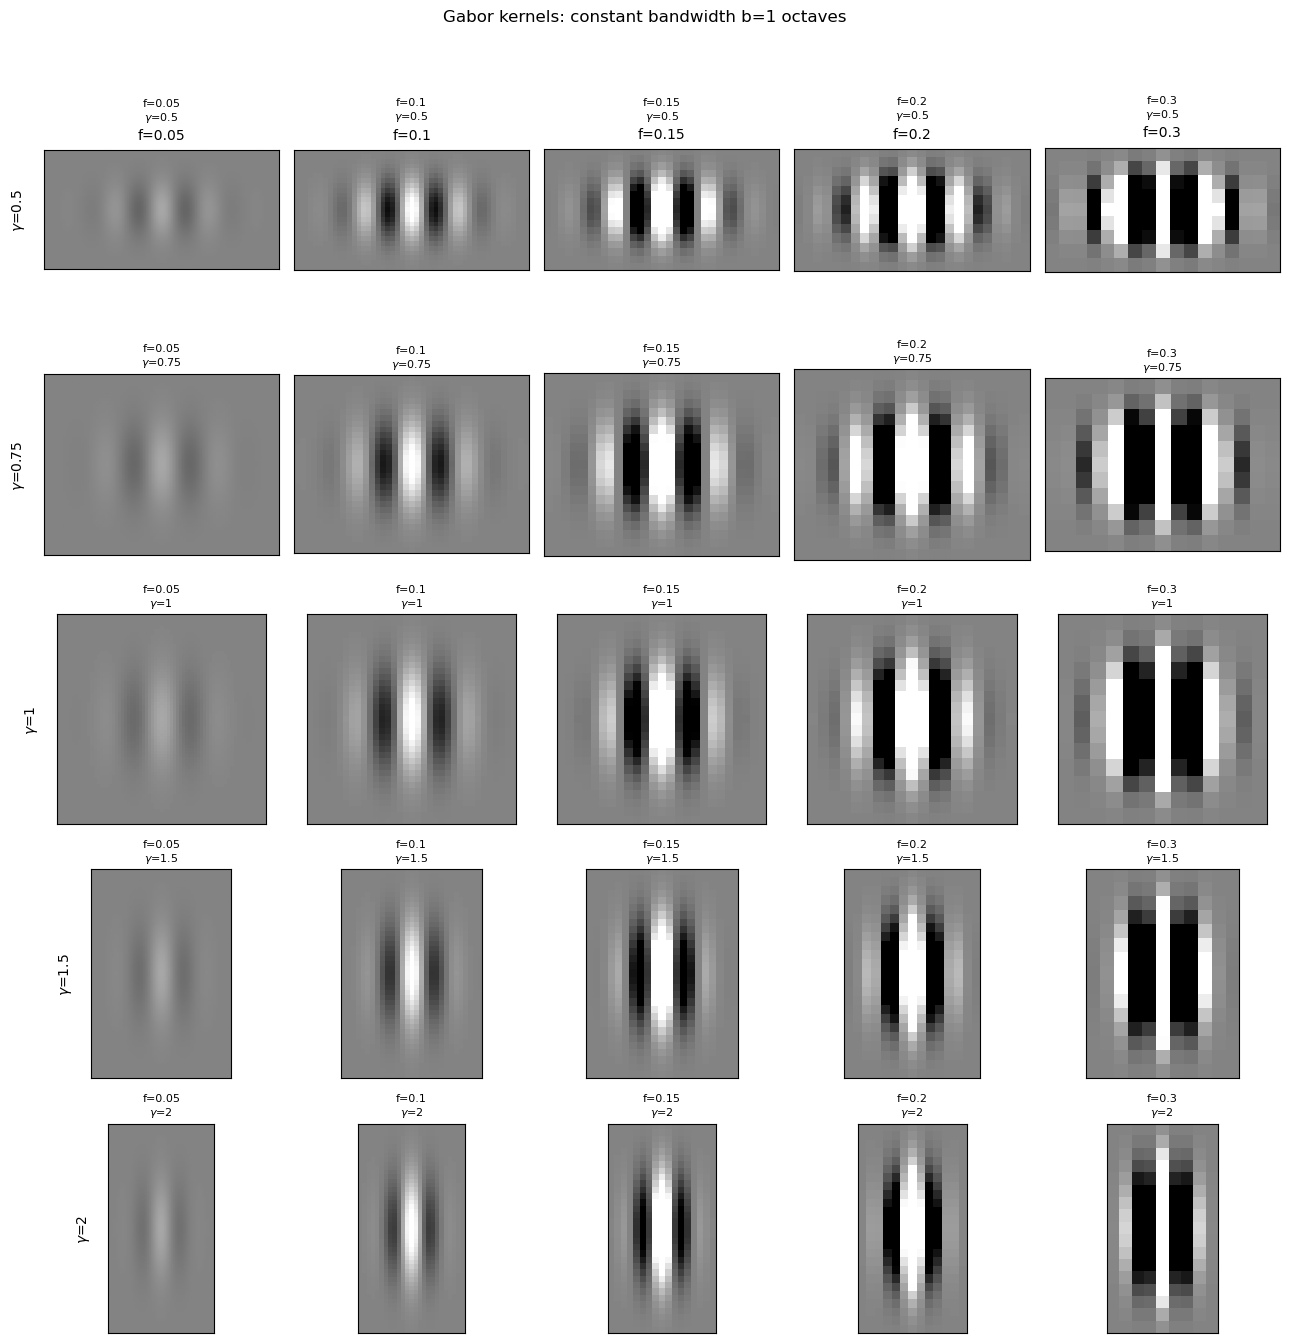

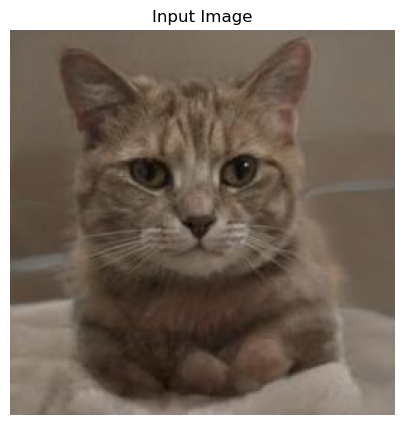

Applying filter bank...
Done.


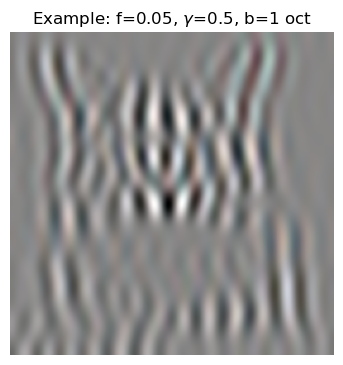

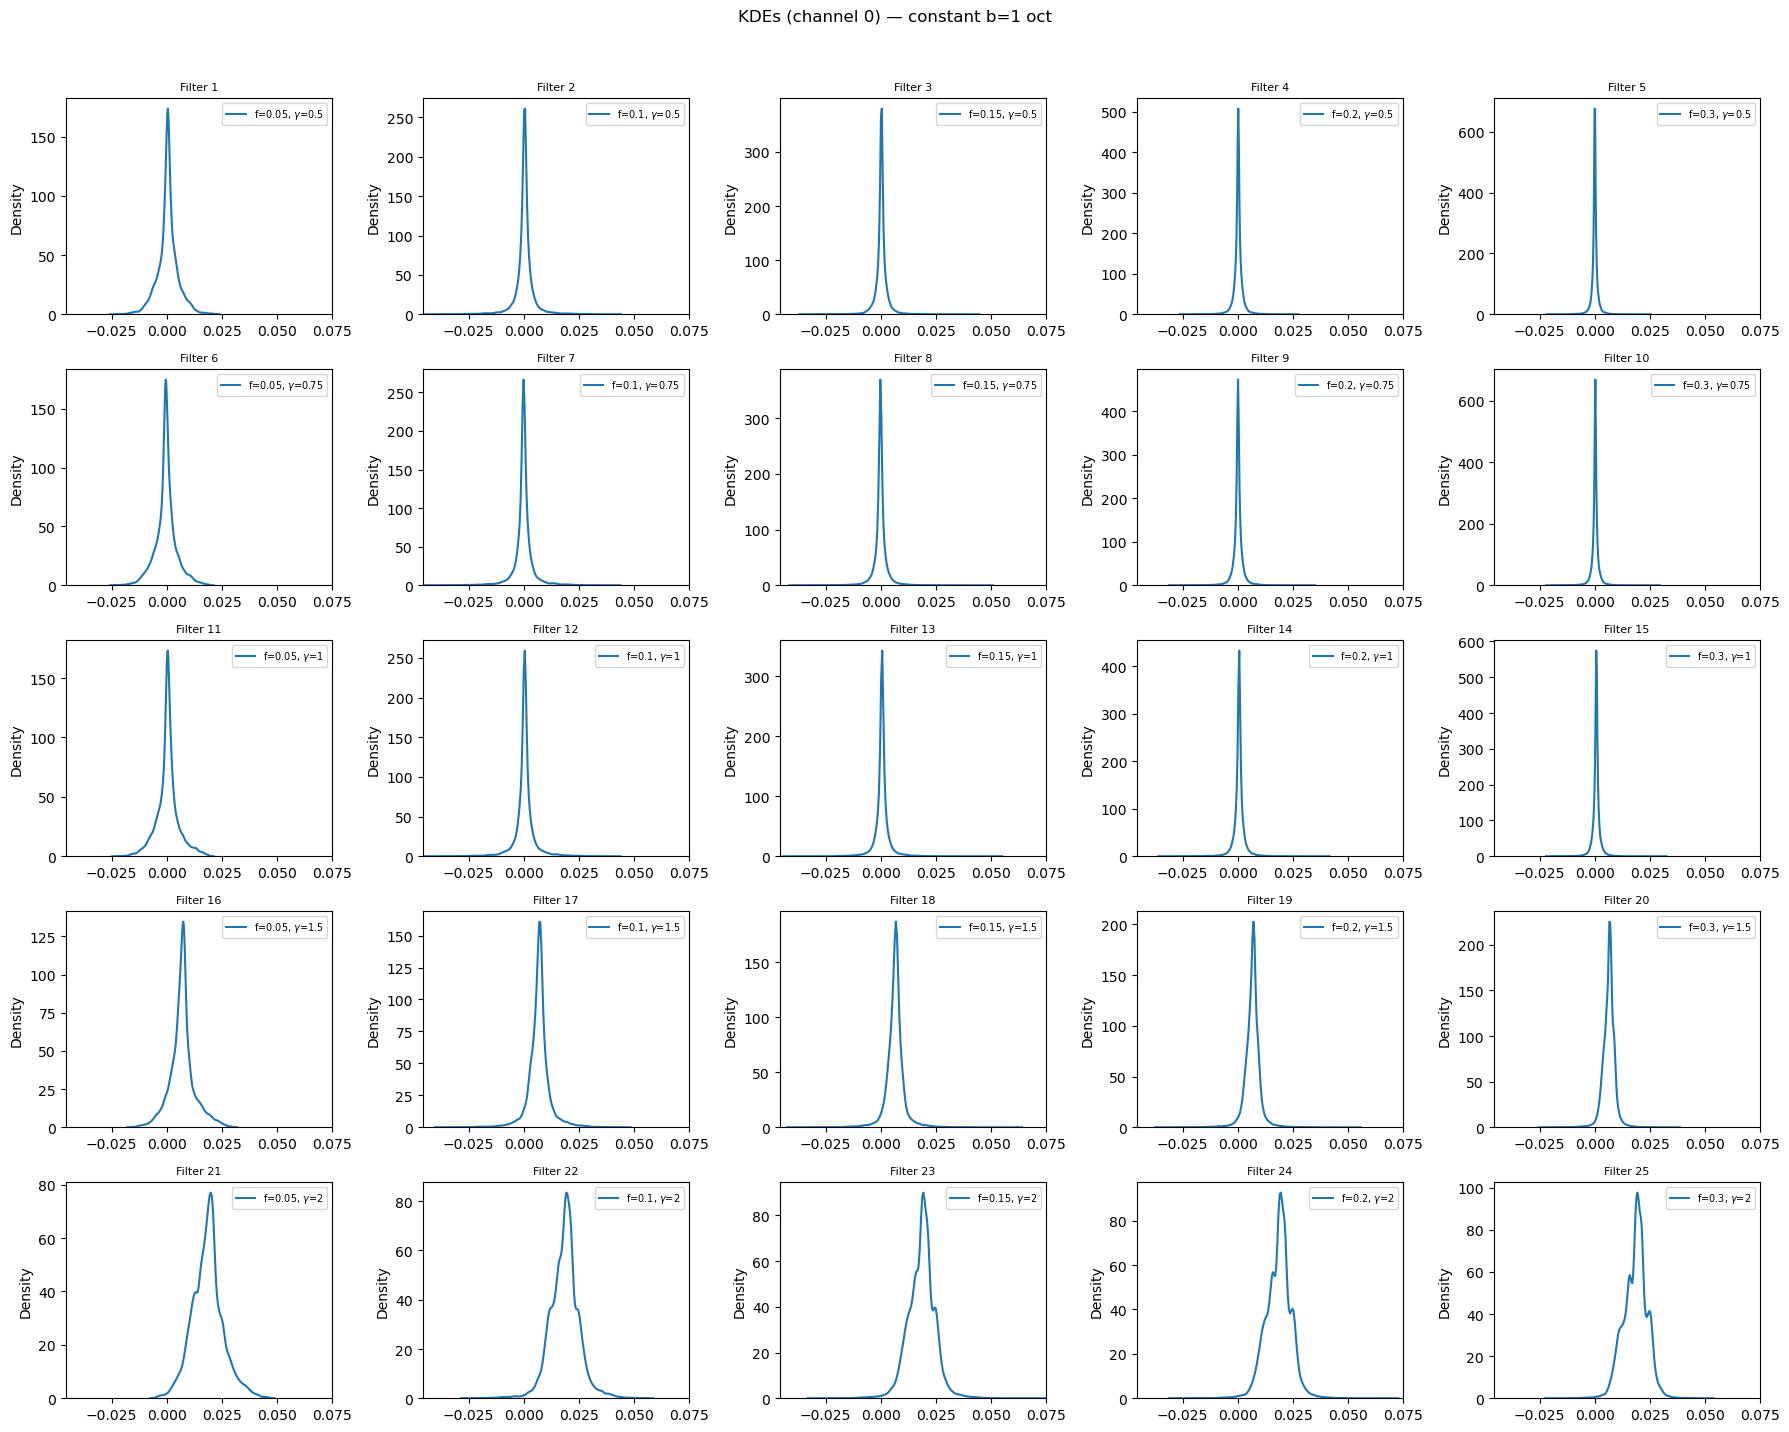

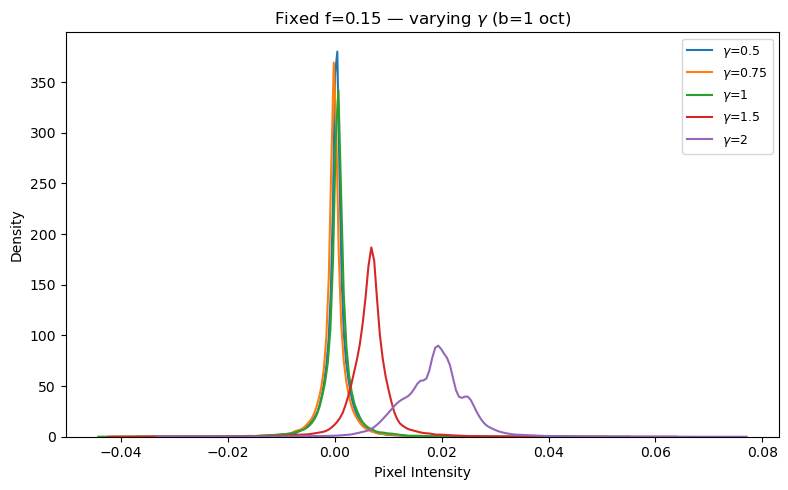

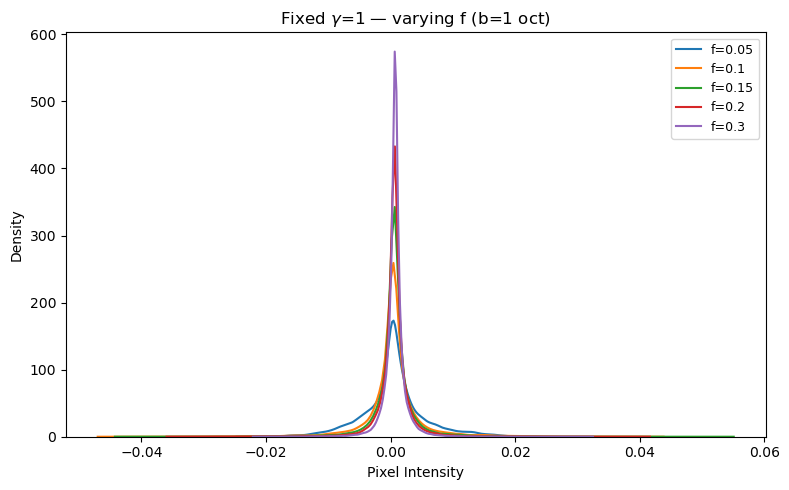

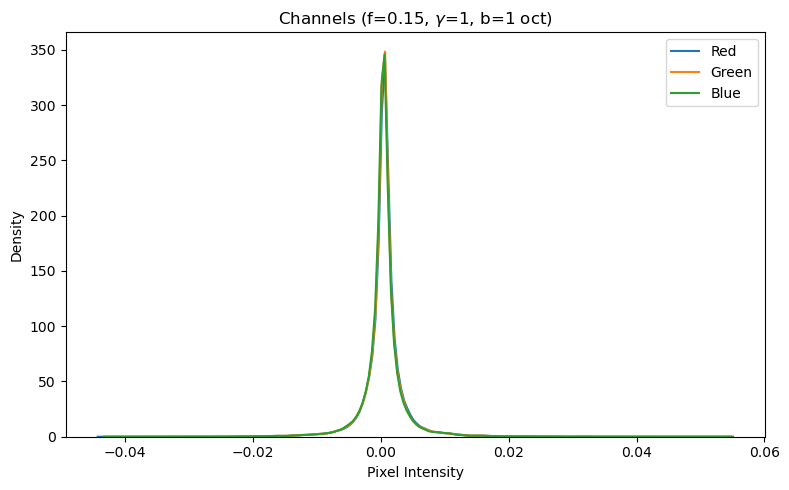

Analysis complete.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import img_as_float, exposure
from skimage.filters import gabor_kernel
import scipy.ndimage as ndi
from PIL import Image
import os

# ============================================================
# 0) Utility
# ============================================================
def _nice(val, digits=3):
    return f"{val:.{digits}g}"

def _fmt_gamma(g):
    return rf"$\gamma$={_nice(g)}"

# ============================================================
# 1) Gabor builders
# ============================================================
def sigma_from_bandwidth(frequency, bandwidth_octaves):
    """
    Map bandwidth (octaves) + center frequency -> isotropic sigma.
    """
    b = float(bandwidth_octaves)
    f = float(frequency)
    ln2 = np.log(2.0)
    # Common closed-form relation for Gabors:
    # sigma = (sqrt(2*ln2) / (2*pi*f)) * ((2^b + 1)/(2^b - 1))
    sigma = (np.sqrt(2 * ln2) / (2 * np.pi * f)) * ((2 ** b + 1) / (2 ** b - 1))
    return sigma

def build_gabor_filter_bank_const_bw_aspect(
    frequencies=(0.05, 0.1, 0.2, 0.3, 0.4),
    bandwidth=1.0,                 # fixed b (octaves)
    gammas=(0.5, 0.75, 1.0, 1.5, 2.0),  # aspect ratios gamma = sigma_y / sigma_x
    theta=0,
    n_stds=3,
    normalize_kernel=False  # optional: L1 normalize each kernel
):
    """
    Build a bank that keeps bandwidth fixed while sweeping frequency and aspect ratio (gamma).
    For each (f, b), compute isotropic sigma, then set (sigma_x, sigma_y) with constant geometric mean.
    """
    filters = []
    for f in frequencies:
        sigma_iso = sigma_from_bandwidth(f, bandwidth)
        for gamma in gammas:
            sx = sigma_iso / np.sqrt(gamma)
            sy = sigma_iso * np.sqrt(gamma)
            kern = np.real(gabor_kernel(frequency=f, theta=theta,
                                        sigma_x=sx, sigma_y=sy, n_stds=n_stds))
            if normalize_kernel:
                s = np.sum(np.abs(kern))
                if s > 0:
                    kern = kern / s
            filters.append({
                'bandwidth': bandwidth,
                'frequency': f,
                'theta': theta,
                'gamma': gamma,
                'sigma_x': sx,
                'sigma_y': sy,
                'kernel': kern,
                'kernel_rgb': np.stack([kern]*3, axis=-1)
            })
    # sort for stable plotting (rows=gamma ascending, cols=frequency ascending)
    filters.sort(key=lambda d: (d['gamma'], d['frequency']))
    return filters

# ============================================================
# 2) Visualize kernels (rows=gamma, cols=frequency)
# ============================================================
def plot_filter_bank_freq_gamma(filters, suptitle=None):
    freqs  = sorted({f['frequency'] for f in filters})
    gammas = sorted({f['gamma'] for f in filters})
    fmap = {(f['gamma'], f['frequency']): i for i, f in enumerate(filters)}

    # consistent colormap scaling across all kernels
    all_vals = np.concatenate([f['kernel'].ravel() for f in filters])
    vmin, vmax = np.percentile(all_vals, [1, 99])  # robust limits

    nrows, ncols = len(gammas), len(freqs)
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*2.6, nrows*2.6),
                             squeeze=False)
    for r, g in enumerate(gammas):
        for c, freq in enumerate(freqs):
            ax = axes[r, c]
            idx = fmap.get((g, freq), None)
            if idx is not None:
                kern = filters[idx]['kernel']
                ax.imshow(kern, cmap='gray', vmin=vmin, vmax=vmax)
                ax.set_title(f"f={_nice(freq)}\n{_fmt_gamma(g)}", fontsize=8)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_aspect('equal')

    # column labels (frequencies) at the top
    for c, freq in enumerate(freqs):
        axes[0, c].set_xlabel(f"f={_nice(freq)}", labelpad=8)
        axes[0, c].xaxis.set_label_position('top')

    # row labels (gammas)
    for r, g in enumerate(gammas):
        axes[r, 0].set_ylabel(_fmt_gamma(g), rotation=90, labelpad=12)

    st = suptitle or f"Gabor kernels: constant bandwidth b={_nice(filters[0]['bandwidth'])} octaves"
    plt.suptitle(st, y=1.03)
    plt.tight_layout()
    plt.show()

# ============================================================
# 3) Convolve image
# ============================================================
def apply_filter_bank(image, filters):
    """
    Applies each Gabor filter (real part) to the input RGB image.
    Keeps metadata (bandwidth, frequency, theta, gamma, sigmas).
    """
    responses = []
    image = img_as_float(image)
    for f in filters:
        out = np.zeros_like(image)
        for ch in range(image.shape[2]):
            out[:, :, ch] = ndi.convolve(image[:, :, ch], f['kernel'], mode='reflect')
        responses.append({
            'bandwidth': f['bandwidth'],
            'frequency': f['frequency'],
            'theta': f['theta'],
            'gamma': f['gamma'],
            'sigma_x': f['sigma_x'],
            'sigma_y': f['sigma_y'],
            'response': out
        })
    return responses

# ============================================================
# 3a) Normalize response for display
# ============================================================
def reconstruct_normalized_rgb(response):
    norm = np.zeros_like(response)
    for ch in range(3):
        norm[:, :, ch] = exposure.rescale_intensity(response[:, :, ch],
                                                    in_range='image',
                                                    out_range=(0, 1))
    return norm

# ============================================================
# 4) KDE plots
# ============================================================
def plot_kdes_grid(responses, channel=0, num=None, suptitle=None):
    """
    Grid of KDEs; labels include f and gamma; global x-limits unified.
    """
    sel = responses if num is None else responses[:num]
    if not sel:
        print("No responses to plot.")
        return

    all_vals = np.hstack([r['response'][:, :, channel].ravel() for r in sel])
    vmin, vmax = np.min(all_vals), np.max(all_vals)

    n = len(sel)
    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.6, nrows*2.8), squeeze=False)
    axes = axes.flatten()

    for i, r in enumerate(sel):
        ax = axes[i]
        vals = r['response'][:, :, channel].ravel()
        sns.kdeplot(vals, ax=ax, label=rf"f={_nice(r['frequency'])}, { _fmt_gamma(r['gamma']) }")
        ax.set_xlim(vmin, vmax)
        ax.legend(fontsize=7, loc='upper right')
        ax.set_title(f"Filter {i+1}", fontsize=8)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    st = suptitle or rf"KDEs (channel {channel}) — constant b={_nice(sel[0]['bandwidth'])} oct"
    plt.suptitle(st, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_overlay_fixed_frequency_varying_gamma(responses, fixed_frequency, channel=0):
    sel = [r for r in responses if np.isclose(r['frequency'], fixed_frequency)]
    sel.sort(key=lambda d: d['gamma'])
    if not sel:
        print(f"No responses for f={fixed_frequency}")
        return
    plt.figure(figsize=(8, 5))
    for r in sel:
        vals = r['response'][:, :, channel].ravel()
        sns.kdeplot(vals, label=_fmt_gamma(r['gamma']))
    plt.title(rf"Fixed f={_nice(fixed_frequency)} — varying $\gamma$ (b={_nice(sel[0]['bandwidth'])} oct)")
    plt.xlabel("Pixel Intensity"); plt.ylabel("Density")
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_overlay_fixed_gamma_varying_frequency(responses, fixed_gamma, channel=0):
    sel = [r for r in responses if np.isclose(r['gamma'], fixed_gamma)]
    sel.sort(key=lambda d: d['frequency'])
    if not sel:
        print(f"No responses for gamma={fixed_gamma}")
        return
    plt.figure(figsize=(8, 5))
    for r in sel:
        vals = r['response'][:, :, channel].ravel()
        sns.kdeplot(vals, label=f"f={_nice(r['frequency'])}")
    plt.title(rf"Fixed $\gamma$={_nice(fixed_gamma)} — varying f (b={_nice(sel[0]['bandwidth'])} oct)")
    plt.xlabel("Pixel Intensity"); plt.ylabel("Density")
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_overlay_kde_three_channels(responses, fixed_frequency, fixed_gamma):
    sel = [r for r in responses
           if np.isclose(r['frequency'], fixed_frequency)
           and np.isclose(r['gamma'], fixed_gamma)]
    if not sel:
        print(f"No filter for f={fixed_frequency}, gamma={fixed_gamma}")
        return
    r = sel[0]
    names = {0: "Red", 1: "Green", 2: "Blue"}
    plt.figure(figsize=(8, 5))
    for ch in [0, 1, 2]:
        vals = r['response'][:, :, ch].ravel()
        sns.kdeplot(vals, label=names[ch])
    plt.title(rf"Channels (f={_nice(fixed_frequency)}, $\gamma$={_nice(fixed_gamma)}, b={_nice(r['bandwidth'])} oct)")
    plt.xlabel("Pixel Intensity"); plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# 5) Image loader (npz or common image formats)
# ============================================================
def load_image_any(path_or_npz):
    if path_or_npz.lower().endswith(".npz"):
        npz = np.load(path_or_npz)
        key = list(npz.files)[0]
        img = npz[key]
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        img = img.astype(float)
        if img.max() > 1.0:
            img /= img.max()
        return img
    else:
        img = np.array(Image.open(path_or_npz).convert('RGB'), dtype=float)
        if img.max() > 1.0:
            img /= 255.0
        return img

# ============================================================
# 6) Main
# ============================================================
if __name__ == '__main__':
    # --- Define your filter bank parameters ---
    frequencies = [0.05, 0.1, 0.15, 0.2, 0.3]
    bandwidth   = 1.0                      # fixed b (octaves)
    gammas      = [0.5, 0.75, 1.0, 1.5, 2.0]
    theta       = 0

    # (a) Build filter bank (constant bandwidth, varying f and gamma)
    gabor_filters = build_gabor_filter_bank_const_bw_aspect(
        frequencies=frequencies,
        bandwidth=bandwidth,
        gammas=gammas,
        theta=theta,
        n_stds=3,
        normalize_kernel=False  # set True if you want energy-normalized kernels
    )
    print(f"Built {len(gabor_filters)} Gabor filters.")

    # (b) Visualize kernels with correct labels (rows=gamma, cols=f)
    plot_filter_bank_freq_gamma(
        gabor_filters,
        suptitle=None  # or pass a custom title
    )

    # (c) Load your image (npz or standard image path)
    img_path = '/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/cat1589.jpg'
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = load_image_any(img_path)

    # Quick display
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    # (d) Apply the filter bank
    print("Applying filter bank...")
    responses = apply_filter_bank(img, gabor_filters)
    print("Done.")

    # (e) Show one example reconstruction
    ex = responses[0]
    recon = reconstruct_normalized_rgb(ex['response'])
    plt.figure(figsize=(4.2, 4.2))
    plt.imshow(recon)
    plt.title(rf"Example: f={_nice(ex['frequency'])}, $\gamma$={_nice(ex['gamma'])}, b={_nice(ex['bandwidth'])} oct")
    plt.axis('off')
    plt.show()

    # (f) Plot all KDEs (red channel)
    plot_kdes_grid(responses, channel=0)

    # (g1) Overlay: fixed frequency, varying gamma
    fixed_freq = frequencies[len(frequencies)//2]
    plot_overlay_fixed_frequency_varying_gamma(responses, fixed_freq, channel=0)

    # (g2) Overlay: fixed gamma, varying frequency
    fixed_gamma = 1.0
    plot_overlay_fixed_gamma_varying_frequency(responses, fixed_gamma, channel=0)

    # (h) Overlay KDE for three channels for one chosen filter
    plot_overlay_kde_three_channels(responses,
                                    fixed_frequency=fixed_freq,
                                    fixed_gamma=fixed_gamma)

    print("Analysis complete.")
